In [1]:
#some boring bookkeeping

%matplotlib notebook
import matplotlib.pyplot as plt

#matplotlib.rcParams['figure.figsize'] = [10,4]

In [2]:
#from nhmm import *
from pomegranate import *
import pomegranate
import numpy as np
import scipy.signal
#from scipy.preprocessing import scale
from sklearn.preprocessing import scale

from tqdm import tqdm

# print(pomegranate.utils.is_gpu_enabled())
# pomegranate.utils.enable_gpu()
# print(pomegranate.utils.is_gpu_enabled())

import wfdb
import numpy as np
import scipy.signal

In [25]:
signals, fields = wfdb.rdsamp('data/mitdb/100')

# signal = signals[:200000,0]
signal = signals[:,0]


# signal = decimate(signal)
# signal = scipy.signal.decimate(signal,2,ftype='fir')

# signal = scipy.signal.decimate(signal,4,ftype='fir')
org0 = signal

s0 = np.diff(org0)

#signals, fields

signals, fields = wfdb.rdsamp('data/mitdb/102')
signal = signals[:,0]
org2 = signal
s2 = np.diff(org2)

signals, fields = wfdb.rdsamp('data/mitdb/234')
signal = signals[:,0]
org1 = signal
s1 = np.diff(org1)

<IPython.core.display.Javascript object>


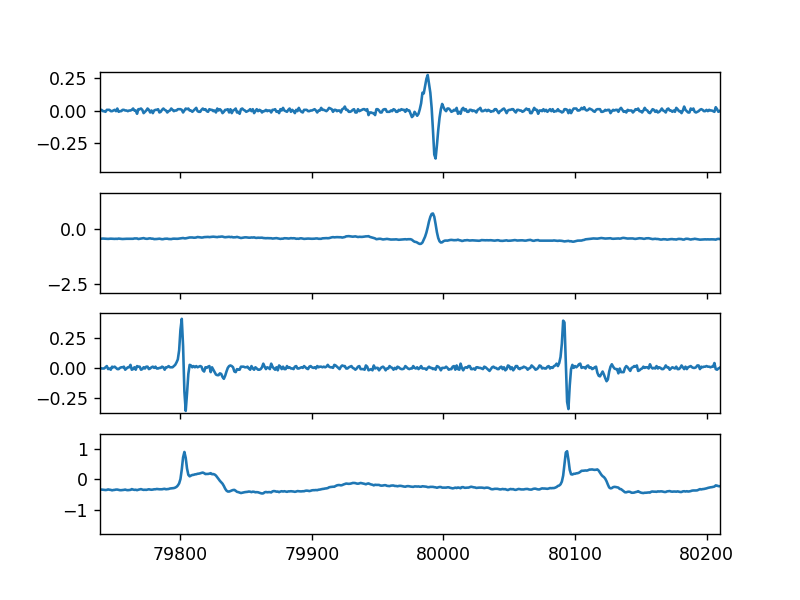

In [26]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True)

ax1.plot(s0)
ax2.plot(org0)

ax3.plot(s2)
ax4.plot(org2)
# ax4.plot(s[:,0])

In [5]:
from pomegranate import *

num = 512

states = [None]*num

for i in range(num):
#     dist = NormalDistribution((np.random.random()-0.5)/1000, 1./10000, min_std=1e-9)
    dist = NormalDistribution(s0[880+i//2], np.random.random()/1000, min_std=1e-9)

    states[i] = State(dist, name="s{:03d}".format(i))

model = HiddenMarkovModel()
model.add_states(states)

for i in range(num):
    model.add_transition(model.start, states[i], 1.0)

for i in range(num):
    model.add_transition(states[i], states[i], np.random.random())
    for j in range(i,i+6):
#     for j in range(0,num):    
        model.add_transition(states[i], states[j%num], np.random.random())


model.add_transition(states[num-1],states[0], 1.0)

model.bake(verbose=True)



None : None-start summed to 512.0, normalized to 1.0
None : s000 summed to 2.49868512, normalized to 1.0
None : s001 summed to 1.92558172, normalized to 1.0
None : s002 summed to 2.8484566, normalized to 1.0
None : s003 summed to 2.96898479, normalized to 1.0
None : s004 summed to 2.43254374, normalized to 1.0
None : s005 summed to 3.75345125, normalized to 1.0
None : s006 summed to 3.33402646, normalized to 1.0
None : s007 summed to 1.20628477, normalized to 1.0
None : s008 summed to 2.96051345, normalized to 1.0
None : s009 summed to 3.03691896, normalized to 1.0
None : s010 summed to 2.48470169, normalized to 1.0
None : s011 summed to 3.26298589, normalized to 1.0
None : s012 summed to 3.61661047, normalized to 1.0
None : s013 summed to 2.96621964, normalized to 1.0
None : s014 summed to 3.3123143, normalized to 1.0
None : s015 summed to 3.11689224, normalized to 1.0
None : s016 summed to 2.10128317, normalized to 1.0
None : s017 summed to 3.89939765, normalized to 1.0
None : s018 s

<IPython.core.display.Javascript object>


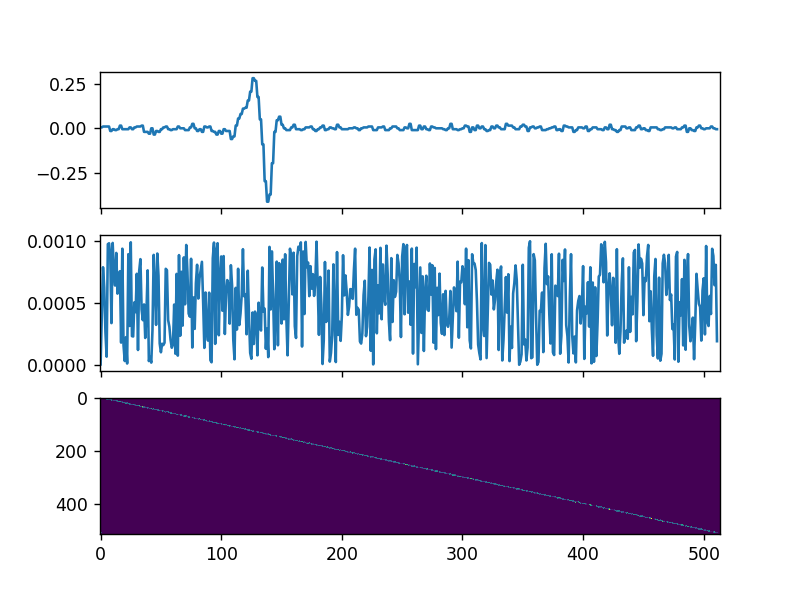

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)

means = np.array([ state.distribution.parameters[0] for state in model.states if state.distribution ])
covars  = np.array([ state.distribution.parameters[1] for state in model.states if state.distribution ])

ax1.plot(means)
ax2.plot(covars)

ax3.imshow(model.dense_transition_matrix(),aspect='auto')


In [31]:
model.fit([s0, s1, s2],
      verbose=True,
      min_iterations=1,
      max_iterations=100,
      transition_pseudocount = 0.0001,
      emission_pseudocount = 0.0001,
#       algorithm='baum-welch',
      algorithm='viterbi',
      n_jobs=8
     )

KeyboardInterrupt: 

In [7]:
p_trans = model.dense_transition_matrix()[:-1]
p_means = means
p_covars = covars

<IPython.core.display.Javascript object>


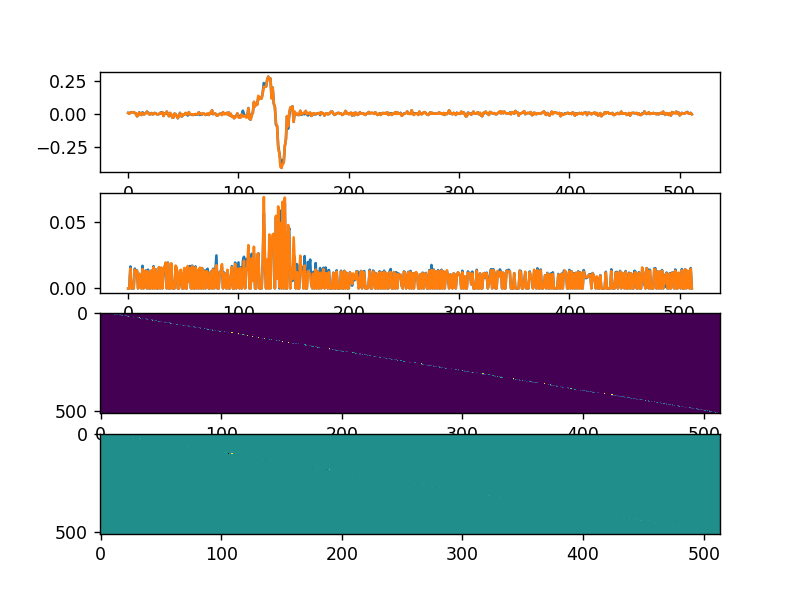

In [29]:

trans = model.dense_transition_matrix()[:-1]
means = np.array([ state.distribution.parameters[0] for state in model.states if state.distribution ])
covars  = np.array([ state.distribution.parameters[1] for state in model.states if state.distribution ])        
        
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)

ax1.plot(means)
ax1.plot(p_means)

ax2.plot(covars)
ax2.plot(p_covars)

ax3.imshow(trans, aspect='auto')
ax4.imshow(trans-p_trans, aspect='auto')

p_trans = trans.copy()
p_means = means
p_covars = covars

<IPython.core.display.Javascript object>


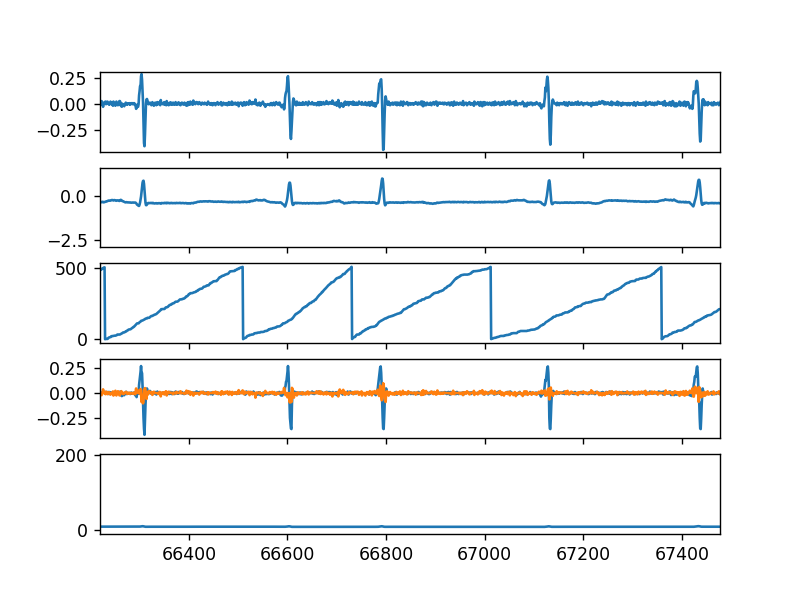

In [30]:
prediction = model.predict(s0, algorithm='viterbi')[1:]

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1, sharex=True)

ax1.plot(s0)
ax2.plot(org0)
ax3.plot(prediction)
# ax3.plot(model.predict(s0, algorithm='map'))
ax4.plot(means[prediction])
ax4.plot(means[prediction]-s0)

ax5.plot(np.cumsum(means[prediction]))

In [ ]:
fig, ax = plt.subplots()

hist = np.histogram(prediction,bins=range(num+1),density=True)[0]
entr = np.nan_to_num(-hist*np.nan_to_num(np.log2(hist))).sum()
print(entr)

ax.plot(hist)
if 'pr_hist' in globals():
    ax.plot(pr_hist)
pr_hist = hist

In [ ]:
def change(model):
    ser = model.to_json()
    import json
    ser = json.loads(ser)
    edges = ser['edges']
#     print("emis")
    for i in range(num):
#         break
        #ser['states'][0]['distribution']['parameters'][0]['0']
        ser = model.to_json()
        ser = json.loads(ser)
        states = ser['states']
        state = states[i]
        dist = state['distribution']['parameters']
        dist[0] *= 1.1
        new_model = HiddenMarkovModel.from_json(json.dumps(ser))
        yield new_model
        dist[0] /= 1.1

        dist[0] *= 0.9
        new_model = HiddenMarkovModel.from_json(json.dumps(ser))
        yield new_model
        dist[0] /= 0.9

        dist[1] *= 1.1
        new_model = HiddenMarkovModel.from_json(json.dumps(ser))
        yield new_model
        dist[1] /= 1.1

        dist[1] *= 0.9
        dist[1] = max(1e-6,dist[1])
        new_model = HiddenMarkovModel.from_json(json.dumps(ser))
        yield new_model
#     print("trans")
    for i in range(len(edges)):
        ser = model.to_json()
        ser = json.loads(ser)
        edges = ser['edges']
        edge = edges[i]
        edge[2] *= 1.1
        new_model = HiddenMarkovModel.from_json(json.dumps(ser))
        yield new_model        


from collections import Counter
counter = 0
def entr_score(model, signal=s0):
    global counter
    counter += 1
    prediction = model.predict(signal, algorithm='map')
#     hist = Counter()
#     total = 0
#     for i in range(len(prediction)-1):
#         f = prediction[i]
#         t = prediction[i+1]
#         hist["{}-{}".format(t,f)] += 1
#         total += 1
# #     print(hist)
#     entr = 0
#     for k in hist:
#         v = hist[k]
#         p = v/total
#         entr += -p * np.log2(p) if v > 0 else 0
    hist = np.histogram(prediction,bins=range(num+1),density=True)[0]
    entr = np.nan_to_num(-hist*np.nan_to_num(np.log2(hist))).sum()
#     print(entr)
    print(counter, end='\r')
    return entr

def mean_cycle_time(model, signal=s0):
    prediction = model.predict(signal, algorithm='viterbi')[1:]
    cycles = []
    last = 0
    for i in range(len(prediction)-1):
        if prediction[i] >= 6 and prediction[i+1] < 6:
            cycles.append(i - last)
            last = i
    return np.mean(cycles)

def l1_score(model, signal=s0):
    means = np.array([ state.distribution.parameters[0] for state in model.states if state.distribution ])
    prediction = model.predict(signal, algorithm='viterbi')[1:]
    prediction = np.array(prediction) #[:-1]
    recons = means[prediction]
    dd = np.sum(np.abs(recons-signal))
    return dd

def dot_score(model, signal=s0):
    means = np.array([ state.distribution.parameters[0] for state in model.states if state.distribution ])
    prediction = model.predict(signal, algorithm='viterbi')[1:]
    prediction = np.array(prediction) #[:-1]
    recons = means[prediction]
    dd = np.sqrt(np.sum((recons-signal)**2))
    return dd

def norm(model, signal):
    means = np.array([ state.distribution.parameters[0] for state in model.states if state.distribution ])
    prediction = model.predict(signal, algorithm='viterbi')[1:]
    prediction = np.array(prediction) #[:-1]
    recons = means[prediction]
    return np.linalg.norm(recons - signal,2)

def score(model, signal=s0, cycle=280, verbose=False):
    global counter
    counter += 1
    
    d1 = norm(model, signal)
    m1 = mean_cycle_time(model, signal)
    
    if verbose:
        print(counter, d1, np.abs(m1 - cycle)/cycle, m1)
    print(counter, end='\r')
    return d1 + np.abs(m1 - cycle)/cycle

score(model,verbose=True), mean_cycle_time(model), dot_score(model), entr_score(model)

In [33]:
import gc
gc.collect()

0

In [ ]:
def average(pairs):
    scores_sum = sum(b[0] for b in pairs)
    first = pairs[0]
    score = first[0]
    model = first[1]
    ser = model.to_json()
    import json
    ser = json.loads(ser)
    
    edges = ser['edges']
    for i in range(len(edges)):
        edges[i][2] *= score/scores_sum
    for i in range(num):
        states = ser['states']
        state = states[i]
        dist = state['distribution']['parameters']
        dist[0] *= score/scores_sum
        dist[1] *= score/scores_sum

    for p in pairs[1:]:
        score = p[0]
        model = p[1]
        m = model.to_json()
        m = json.loads(m)
        for i in range(len(edges)):
            edges[i][2] += m['edges'][i][2] * score/scores_sum
        for i in range(num):
            ser['states'][i]['distribution']['parameters'][0] += m['states'][i]['distribution']['parameters'][0] * score/scores_sum
            ser['states'][i]['distribution']['parameters'][1] += m['states'][i]['distribution']['parameters'][1] * score/scores_sum
    
    return HiddenMarkovModel.from_json(json.dumps(ser))

In [ ]:
model = average([ (1,m) for m in change(model)])

In [ ]:
fit = 0
i = 0

for y in range(100000):
    global counter
    counter = 0
    o = score(model, verbose=True)
    cand = [ (score(new_model), new_model) for new_model in change(model)]
#     print(cand)
    b = min(cand, key=lambda x:x[0])
    if b[0] >= o:
        break
    fits = [ f for f in cand if f[0] < o ]
    model = average(fits)
    print(y, o, b[0], len(fits))
#     model = b[1]
        
print(fit)

In [ ]:
def f(model):
    return score(model), model

In [ ]:
from multiprocessing import Pool

fit = 0
i = 0

pool = Pool(8)


for y in range(100000):
    global counter
    counter = 0
    o = score(model, verbose=True)
#     cand = [ (score(new_model), new_model) for new_model in change(model)]
    cand = pool.map(f,list(change(model)))
#     for x in scores:
#         print(x[0])
#     print(cand)
    b = min(cand, key=lambda x:x[0])
    if b[0] >= o:
        break
    fits = [ f for f in cand if f[0] < o ]
    model = average(fits)
    print(y, o, b[0], len(fits))
#     print(y, o, b[0])
#     model = b[1]
        
print(fit)

In [ ]:
pool.close()

In [ ]:
fit = 0
for i in range(100000):
    new_model = random_change(model)

    o = score(model)
    n = score(new_model)
    if n >= o:
        print(i, 'entr', n, o, end='\r')
        fit += 1
        model = new_model
    else:
        print(i, 'entr', n, o, end='\r')
        
print(fit)

In [ ]:
fig, ax = plt.subplots()

ax.imshow(model.dense_transition_matrix() - new_model.dense_transition_matrix())

In [ ]:
json.loads(model.to_json())

<IPython.core.display.Javascript object>


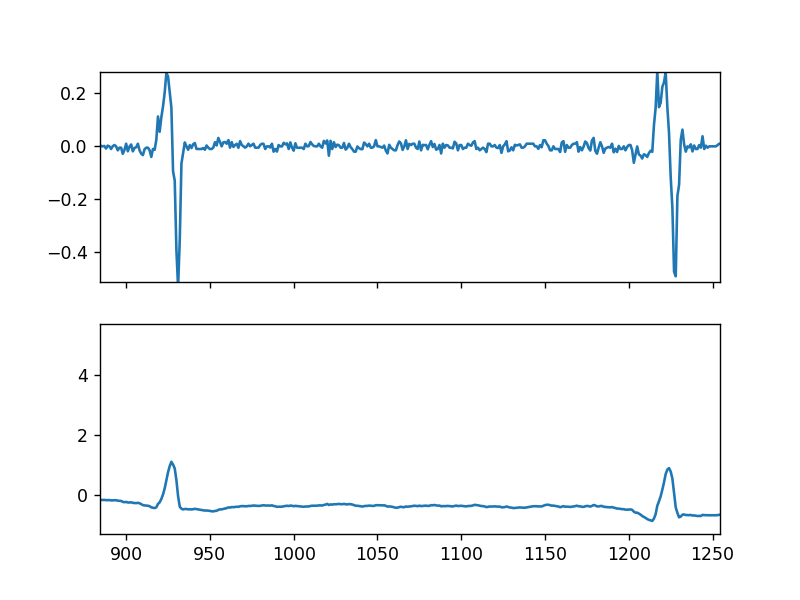

In [21]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)

samp = model.sample(length=10000, path=False)

ax1.plot(samp)
ax2.plot(np.cumsum(samp))

In [ ]:
with open('ff.json', 'w') as f:
    f.write(model.to_json())